In [63]:
# 1. Import 
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os,datetime
from sklearn.metrics import classification_report

In [64]:
# 2. Load
os.chdir("/Users/haris/Desktop/Capstone3(ConcreteCrack)")
Path = "/Users/haris/Desktop/Capstone3(ConcreteCrack)/dataset/Concrete Crack Images for Classification"


In [65]:
train_dir = os.path.join(Path)
validation_dir = os.path.join(Path)

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.


In [66]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 validation_split=0.2,
                                                                 subset="validation",
                                                                 seed=123,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


2024-11-14 08:54:57.558960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


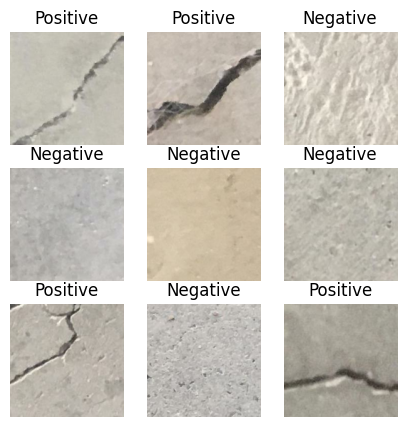

In [67]:
# 3. Inpsect some of the data
class_names = train_dataset.class_names
batch_1 = train_dataset.take(1)

plt.figure(figsize=(5, 5))
for images, labels in batch_1:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [68]:
# 4 Further split the validation dataset into val-test splits
nBatches = validation_dataset.cardinality().numpy()

val_dataset = validation_dataset.take(nBatches//2)
test_dataset = validation_dataset.skip(nBatches//2)

In [69]:
# 5 Convert val and test dataset to prefetch dataset
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [70]:
# 6 Create the data augmentation layers
data_augmentation = tf.keras.Sequential()
data_augmentation = keras.layers.RandomFlip('horizontal')         
data_augmentation = keras.layers.RandomRotation(0.2)

2024-11-14 08:54:58.557408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


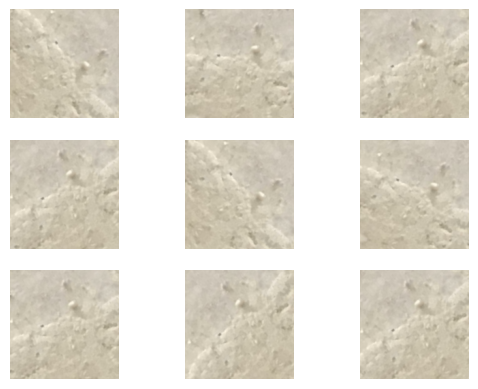

In [71]:
# 7 Lets test out the data augmentation layers
for images, labels in train_dataset.take(1):
    first_image = images[0]
    plt.figure()
    for i in range(9):
        plt.subplot(3,3,i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, axis=0))
        plt.imshow(augmented_image[0]/255.0)
        plt.axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
plt.show()


In [72]:
# 8 Create the preprocess input layer for mobilenet v2

preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [73]:
# 9 Perform transfer learning
# (A) Create the feature extractor from the pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [74]:
# (B) Add in out own classifier
global_avg = keras.layers.GlobalAveragePooling2D()
output_layer = keras.layers.Dense(2,activation='softmax')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

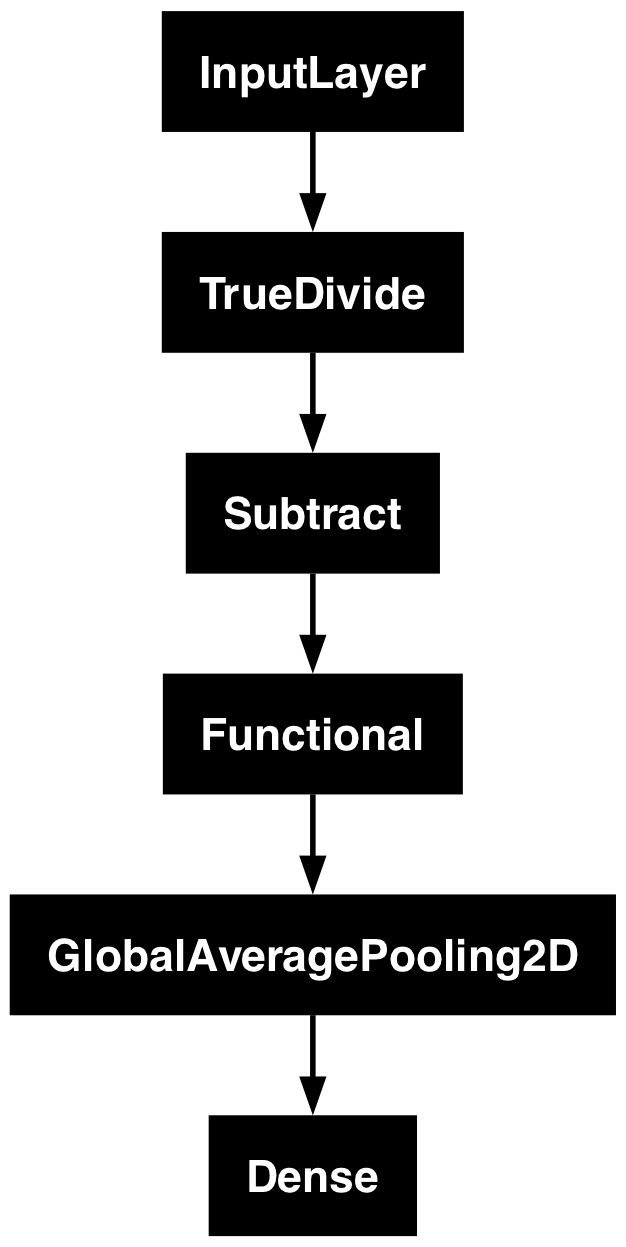

In [75]:
# (C) Use functional API to connect the layers together to form a pipeline

# a. Begin with input
inputs = keras.Input(shape=IMG_SHAPE)

# b. Augmentation
x = data_augmentation(inputs)

# c. Preprocess layer
x = preprocess_input(inputs)

# d. Feature extractor
x = base_model(x)

# e. Classifier
x = global_avg(x)

outputs = output_layer(x)

model = keras.Model(inputs= inputs, outputs= outputs)
model.summary()
keras.utils.plot_model(model)

In [76]:
# 10 Model compile
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [77]:
# Define the callbacks
logpath = "tensorboard/ConcreteCrack/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)
es = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [78]:
# Evaluate the model before training
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 434ms/step - accuracy: 0.5809 - loss: 0.7450


[0.7455443739891052, 0.5822499990463257]

In [80]:
# 11. Training stage
history_first = model.fit(train_dataset,validation_data=val_dataset, epochs=10, callbacks=[tb,es])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 462s 462ms/step - accuracy: 0.9999 - loss: 8.4556e-04 - val_accuracy: 0.9987 - val_loss: 0.0054
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 494s 494ms/step - accuracy: 0.9999 - loss: 8.0660e-04 - val_accuracy: 0.9990 - val_loss: 0.0046
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 489s 489ms/step - accuracy: 0.9999 - loss: 7.7472e-04 - val_accuracy: 0.9985 - val_loss: 0.0050
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 526s 526ms/step - accuracy: 0.9999 - loss: 7.4339e-04 - val_accuracy: 0.9987 - val_loss: 0.0047
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4923s 5s/step - accuracy: 0.9999 - loss: 7.0840e-04 - val_accuracy: 0.9987 - val_loss: 0.0047
Epoch 5: early stopping


In [81]:
# Evaluate the model after training
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 416ms/step - accuracy: 0.9990 - loss: 0.0040


[0.004729503765702248, 0.9987499713897705]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0]
['Positive', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative']


2024-11-14 02:32:10.699440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


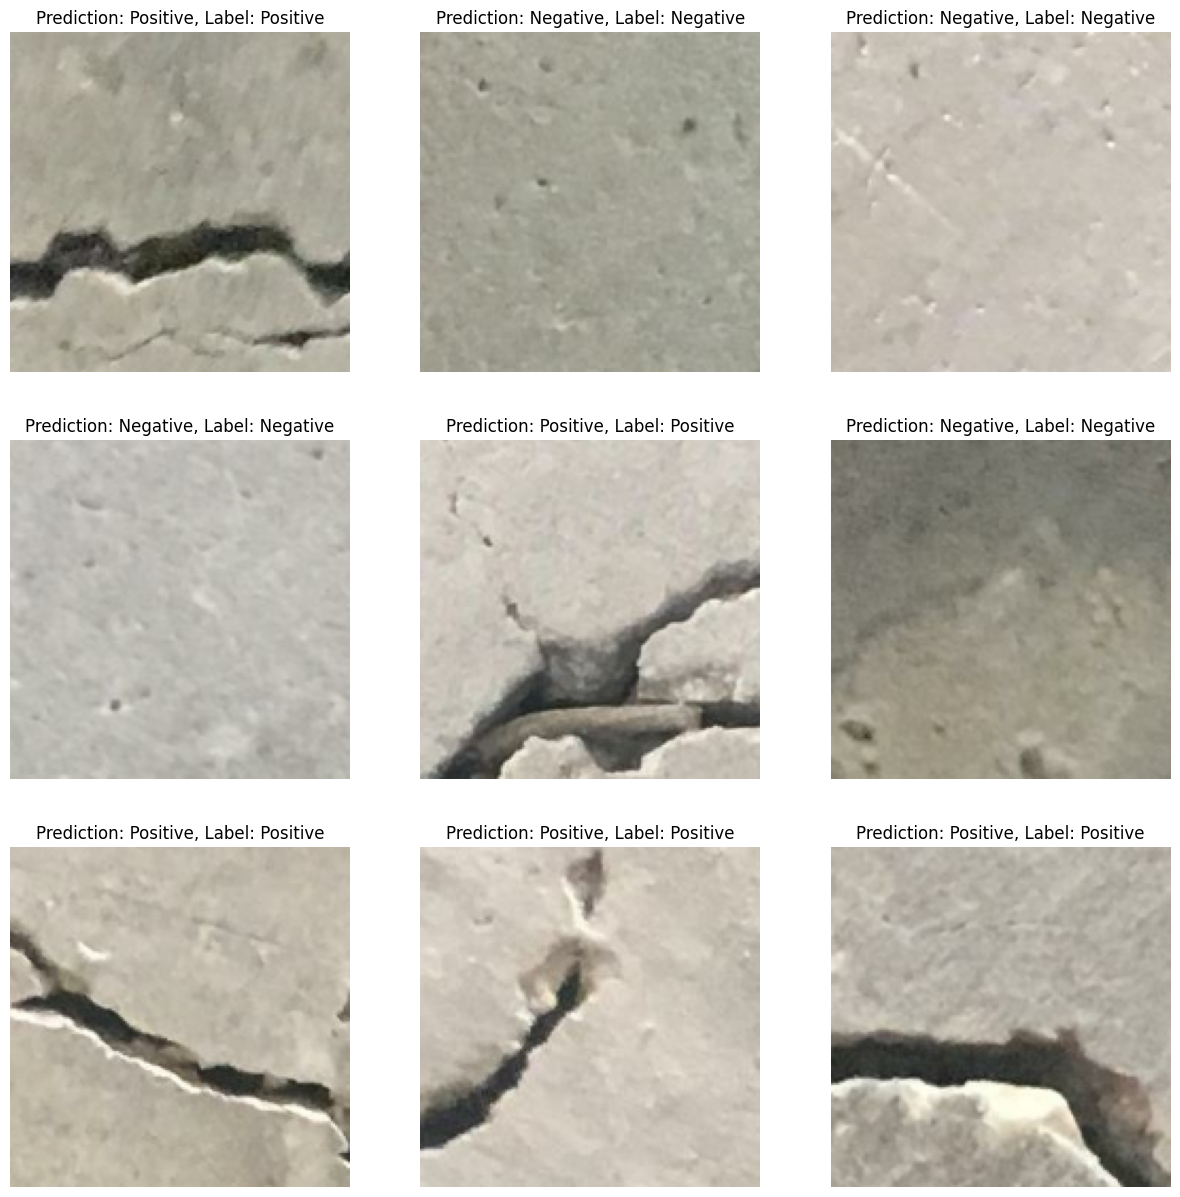

In [ ]:
# 12. Make predictions with test data
for image_batch, labels_batch in test_dataset.take(1):
    prediction = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in prediction]
print(prediction)
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3, i +1)
    plt.axis('off')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(f"Prediction: {predicted_class[i]}, Label: {class_names[labels_batch[i]]}")

In [ ]:
# Save model in .h5
keras.models.save_model(model, "saved_models/ConcreteCrack.h5")